In [1]:
from __future__ import print_function
import argparse
from datetime import datetime
import os
import sys
import time
import scipy.misc
import cv2
from PIL import Image
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from utils import *
from LIP_model import *

In [2]:
N_CLASSES = 20
INPUT_SIZE = (384, 384)
DATA_DIRECTORY = './datasets/examples'
DATA_LIST_PATH = './datasets/examples/list/val.txt'
NUM_STEPS =  6
RESTORE_FROM = './checkpoint'
OUTPUT_DIR = './results'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [3]:
coord = tf.train.Coordinator()
h, w = INPUT_SIZE

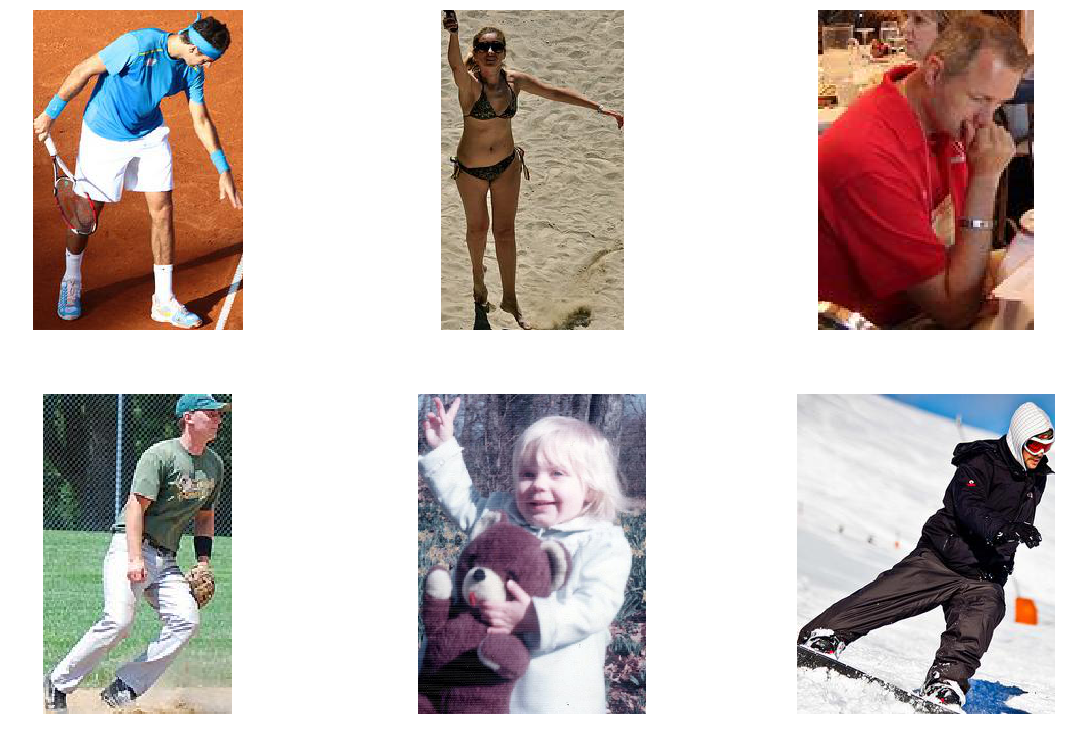

In [4]:
images = []
for img_path in glob.glob('./datasets/examples/images/*.jpg'):
    images.append(mpimg.imread(img_path))

plt.figure(figsize=(20,20))

columns = 3
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.imshow(image)
    plt.axis('off')


Load Image Reader

In [5]:
with tf.name_scope("create_inputs"):
    reader = ImageReader(DATA_DIRECTORY, DATA_LIST_PATH, None, False, False, coord)
    image = reader.image
    image_rev = tf.reverse(image, tf.stack([1]))
    image_list = reader.image_list

image_batch_origin = tf.stack([image, image_rev])
image_batch = tf.image.resize_images(image_batch_origin, [int(h), int(w)])
image_batch075 = tf.image.resize_images(image_batch_origin, [int(h * 0.75), int(w * 0.75)])
image_batch125 = tf.image.resize_images(image_batch_origin, [int(h * 1.25), int(w * 1.25)])

Creating network

In [6]:
with tf.variable_scope('', reuse=False):
    net_100 = JPPNetModel({'data': image_batch}, is_training=False, n_classes=N_CLASSES)
with tf.variable_scope('', reuse=True):
    net_075 = JPPNetModel({'data': image_batch075}, is_training=False, n_classes=N_CLASSES)
with tf.variable_scope('', reuse=True):
    net_125 = JPPNetModel({'data': image_batch125}, is_training=False, n_classes=N_CLASSES)


# parsing net
parsing_fea1_100 = net_100.layers['res5d_branch2b_parsing']
parsing_fea1_075 = net_075.layers['res5d_branch2b_parsing']
parsing_fea1_125 = net_125.layers['res5d_branch2b_parsing']

parsing_out1_100 = net_100.layers['fc1_human']
parsing_out1_075 = net_075.layers['fc1_human']
parsing_out1_125 = net_125.layers['fc1_human']

# pose net
resnet_fea_100 = net_100.layers['res4b22_relu']
resnet_fea_075 = net_075.layers['res4b22_relu']
resnet_fea_125 = net_125.layers['res4b22_relu']

with tf.variable_scope('', reuse=False):
    pose_out1_100, pose_fea1_100 = pose_net(resnet_fea_100, 'fc1_pose')
    pose_out2_100, pose_fea2_100 = pose_refine(pose_out1_100, parsing_out1_100, pose_fea1_100, name='fc2_pose')
    parsing_out2_100, parsing_fea2_100 = parsing_refine(parsing_out1_100, pose_out1_100, parsing_fea1_100, name='fc2_parsing')
    parsing_out3_100, parsing_fea3_100 = parsing_refine(parsing_out2_100, pose_out2_100, parsing_fea2_100, name='fc3_parsing')

with tf.variable_scope('', reuse=True):
    pose_out1_075, pose_fea1_075 = pose_net(resnet_fea_075, 'fc1_pose')
    pose_out2_075, pose_fea2_075 = pose_refine(pose_out1_075, parsing_out1_075, pose_fea1_075, name='fc2_pose')
    parsing_out2_075, parsing_fea2_075 = parsing_refine(parsing_out1_075, pose_out1_075, parsing_fea1_075, name='fc2_parsing')
    parsing_out3_075, parsing_fea3_075 = parsing_refine(parsing_out2_075, pose_out2_075, parsing_fea2_075, name='fc3_parsing')

with tf.variable_scope('', reuse=True):
    pose_out1_125, pose_fea1_125 = pose_net(resnet_fea_125, 'fc1_pose')
    pose_out2_125, pose_fea2_125 = pose_refine(pose_out1_125, parsing_out1_125, pose_fea1_125, name='fc2_pose')
    parsing_out2_125, parsing_fea2_125 = parsing_refine(parsing_out1_125, pose_out1_125, parsing_fea1_125, name='fc2_parsing')
    parsing_out3_125, parsing_fea3_125 = parsing_refine(parsing_out2_125, pose_out2_125, parsing_fea2_125, name='fc3_parsing')


parsing_out1 = tf.reduce_mean(tf.stack([tf.image.resize_images(parsing_out1_100, tf.shape(image_batch_origin)[1:3,]),
                                       tf.image.resize_images(parsing_out1_075, tf.shape(image_batch_origin)[1:3,]),
                                       tf.image.resize_images(parsing_out1_125, tf.shape(image_batch_origin)[1:3,])]), axis=0)
parsing_out2 = tf.reduce_mean(tf.stack([tf.image.resize_images(parsing_out2_100, tf.shape(image_batch_origin)[1:3,]),
                                       tf.image.resize_images(parsing_out2_075, tf.shape(image_batch_origin)[1:3,]),
                                       tf.image.resize_images(parsing_out2_125, tf.shape(image_batch_origin)[1:3,])]), axis=0)
parsing_out3 = tf.reduce_mean(tf.stack([tf.image.resize_images(parsing_out3_100, tf.shape(image_batch_origin)[1:3,]),
                                       tf.image.resize_images(parsing_out3_075, tf.shape(image_batch_origin)[1:3,]),
                                       tf.image.resize_images(parsing_out3_125, tf.shape(image_batch_origin)[1:3,])]), axis=0)

raw_output = tf.reduce_mean(tf.stack([parsing_out1, parsing_out2, parsing_out3]), axis=0)
head_output, tail_output = tf.unstack(raw_output, num=2, axis=0)
tail_list = tf.unstack(tail_output, num=20, axis=2)
tail_list_rev = [None] * 20
for xx in range(14):
    tail_list_rev[xx] = tail_list[xx]
tail_list_rev[14] = tail_list[15]
tail_list_rev[15] = tail_list[14]
tail_list_rev[16] = tail_list[17]
tail_list_rev[17] = tail_list[16]
tail_list_rev[18] = tail_list[19]
tail_list_rev[19] = tail_list[18]
tail_output_rev = tf.stack(tail_list_rev, axis=2)
tail_output_rev = tf.reverse(tail_output_rev, tf.stack([1]))


raw_output_all = tf.reduce_mean(tf.stack([head_output, tail_output_rev]), axis=0)
raw_output_all = tf.expand_dims(raw_output_all, dim=0)
raw_output_all = tf.argmax(raw_output_all, dimension=3)
pred_all = tf.expand_dims(raw_output_all, dim=3) # Create 4-d tensor.

Instructions for updating:
Use the `axis` argument instead


In [7]:
# Which variables to load.
restore_var = tf.global_variables()
# Set up tf session and initialize variables. 
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
init = tf.global_variables_initializer()

sess.run(init)
sess.run(tf.local_variables_initializer())

# Load weights.
loader = tf.train.Saver(var_list=restore_var)
if RESTORE_FROM is not None:
    if load(loader, sess, RESTORE_FROM):
        print(" [*] Load SUCCESS")
    else:
        print(" [!] Load failed...")

INFO:tensorflow:Restoring parameters from ./checkpoint/model.ckpt-205632
Restored model parameters from model.ckpt-205632
 [*] Load SUCCESS


In [8]:
# Start queue threads.
threads = tf.train.start_queue_runners(coord=coord, sess=sess)

# Iterate over training steps.
for step in tqdm(range(NUM_STEPS)):
    parsing_ = sess.run(pred_all)
    print('step {:d}/{:d}'.format(step+1, NUM_STEPS))
    img_split = image_list[step].split('/')
    img_id = img_split[-1][:-4]

    msk = decode_labels(parsing_, num_classes=N_CLASSES)
    parsing_im = Image.fromarray(msk[0])
    parsing_im.save('{}/{}_vis.png'.format(OUTPUT_DIR, img_id))
    cv2.imwrite('{}/{}.png'.format(OUTPUT_DIR, img_id), parsing_[0,:,:,0])

coord.request_stop()
coord.join(threads)

 17%|█▋        | 1/6 [01:39<08:17, 99.47s/it]

step 0


 33%|███▎      | 2/6 [03:19<06:38, 99.52s/it]

step 1


 50%|█████     | 3/6 [04:59<04:59, 99.94s/it]

step 2


 67%|██████▋   | 4/6 [06:41<03:21, 100.61s/it]

step 3


 83%|████████▎ | 5/6 [08:21<01:40, 100.47s/it]

step 4


100%|██████████| 6/6 [10:00<00:00, 100.06s/it]

step 5


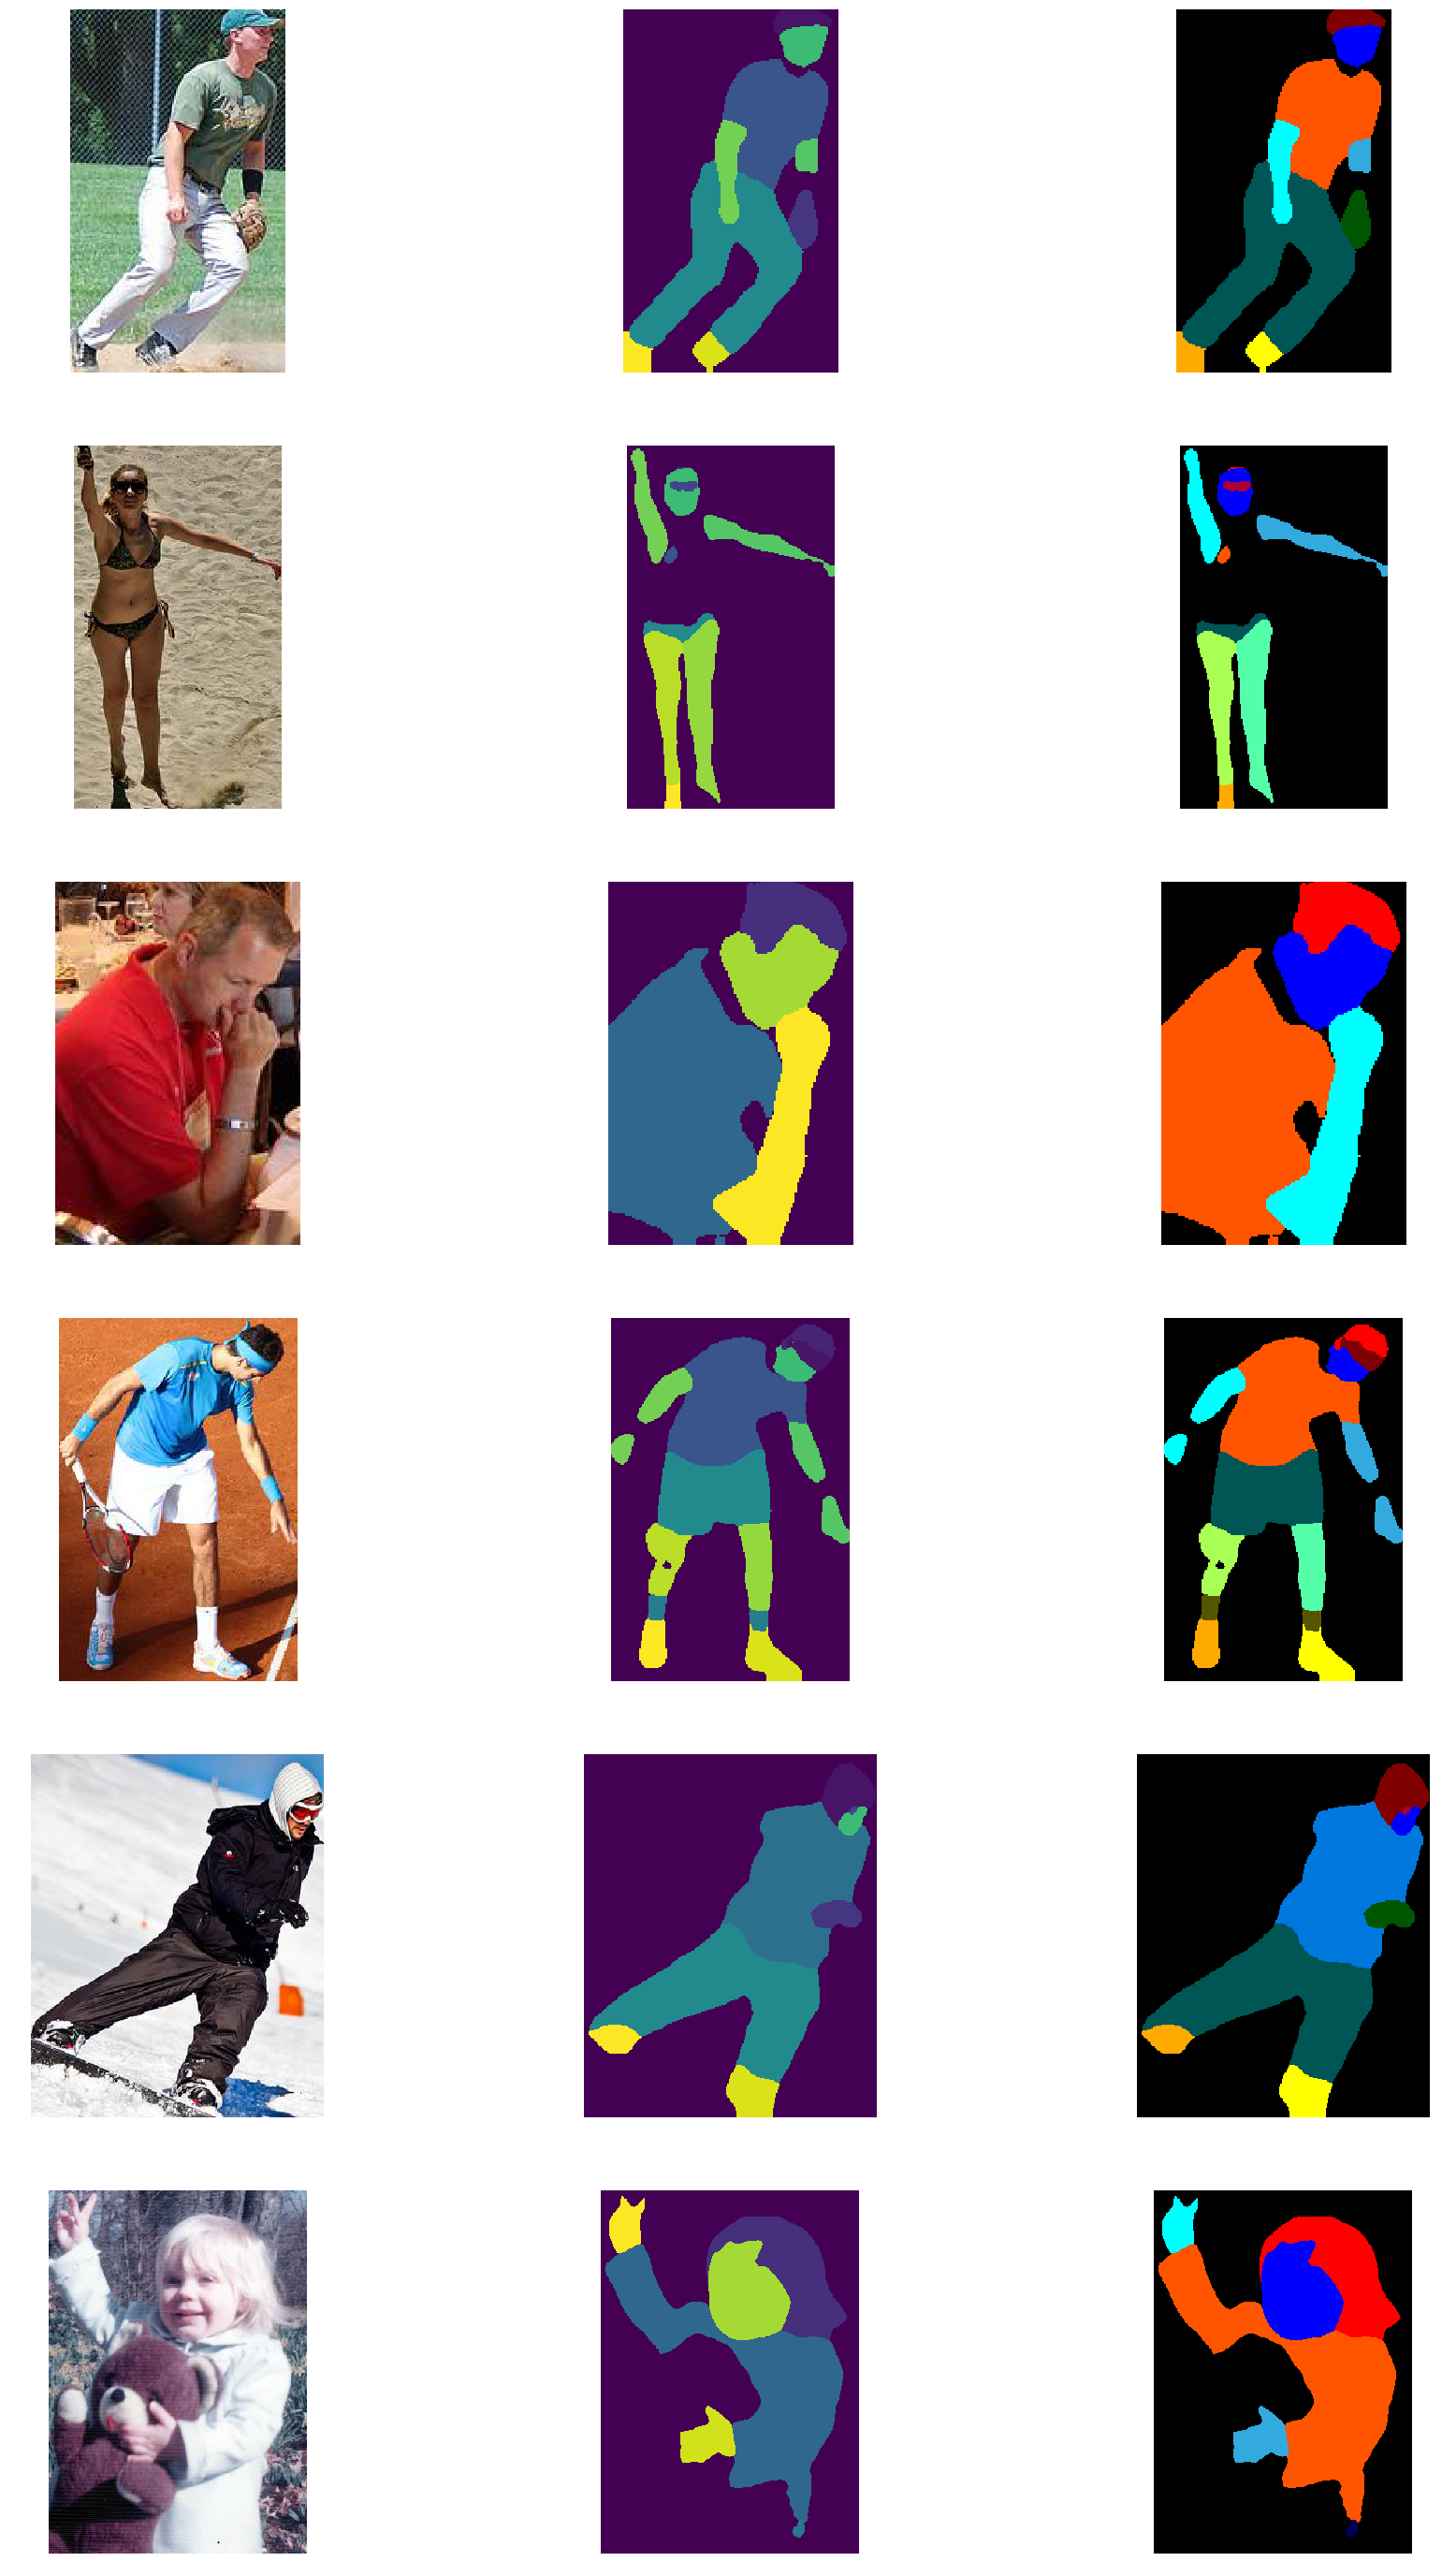

In [16]:
res_path = sorted(glob.glob('./results/*.png'))
img_path = sorted(glob.glob('./datasets/examples/images/*.jpg'))
    
images = []
res = []
results = []
j = 0

for path in res_path:
    results.append(mpimg.imread(path))
for path in img_path:
    images.append(mpimg.imread(path))
for i in range(NUM_STEPS):
    res.append(images[i])
    res.append(results[j])
    res.append(results[j+1])
    j+=2
    
columns = 3
plt.figure(figsize=(30,50))
for i, image in enumerate(res):
    plt.subplot(len(images), columns, i + 1)
    plt.imshow(image)
    plt.axis('off')